In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree

time_conv = 977.79222167

In [6]:
sim_list = ['phantom-vacuum-Sg20-Rc3.5-RadFeed', 'Nbody']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/', output_dir='output'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/' + output_dir
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [3]:
idx_list = np.arange(0, 400, 10)
sn_list = []
fields = None
parttype = None

for idx in tqdm(idx_list):
    sn_list.append(read_snap(idx, 0, lvl='lvl4-torquebug', parttype=parttype, fields=fields))

A Jupyter Widget

In [7]:
idx_list = np.arange(0, 400, 399)
snN_list = []
fields = None
parttype = None

for idx in tqdm(idx_list):
    snN_list.append(read_snap(idx, 1, lvl='lvl4', parttype=parttype, fields=fields))

A Jupyter Widget

In [8]:
dir(sn_list[-1].part4)

['Acceleration',
 'BirthDensity',
 'BirthPos',
 'BirthVel',
 'ColumnDensity',
 'Coordinates',
 'CumFeedbackMomentum',
 'CumInjFeedbackMomentum',
 'CumInjFeedbackMomentumAGB',
 'CumSNIINumber',
 'CumSNIaNumber',
 'Cum_FeedbackAngMomentumAGBVec',
 'Cum_FeedbackAngMomentumInjectedVec',
 'Cum_RadAngMomentumRealInjectedVec',
 'Cum_RadMomentumRealInjected',
 'Cum_RadiationMomentumReleased',
 'FeedbackEnergy',
 'FeedbackMomentum',
 'FeedbackMomentumAGB',
 'GFM_InitialMass',
 'GFM_Metallicity',
 'GFM_Metals',
 'GFM_StellarFormationTime',
 'LocISMDens',
 'MassReleased',
 'Masses',
 'NormSphRadFeedback',
 'ParticleIDs',
 'Potential',
 'RadCoolShutoffTime',
 'RadFeedTau',
 'RadFeed_NumNgb',
 'RadiationMomentumReleased',
 'SNIINumber',
 'SNIaNumber',
 'Softenings',
 'StarsHsml',
 'StarsMaxRadius',
 'StromgrenRadius',
 'Velocities',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getite

In [9]:
def compute_particle_dLz(sn, center=np.array([200., 200., 200.])):
    if sn.NumPart_Total[4] > 0:
        rad_mom = sn.part4.Cum_RadAngMomentumRealInjectedVec
        AGB_mom = sn.part4.Cum_FeedbackAngMomentumAGBVec
        SNe_mom = sn.part4.Cum_FeedbackAngMomentumInjectedVec
        
        dLz_rad = np.sum(rad_mom[:,2])
        dLz_AGB = np.sum(AGB_mom[:,2])
        dLz_SNe = np.sum(SNe_mom[:,2])
    else:
        dLz_rad = 0.0
        dLz_AGB = 0.0
        dLz_SNe = 0.0
    
    return dLz_rad, dLz_AGB, dLz_SNe

def compute_particle_dLx(sn, center=np.array([200., 200., 200.])):
    if sn.NumPart_Total[4] > 0:
        rad_mom = sn.part4.Cum_RadAngMomentumRealInjectedVec
        AGB_mom = sn.part4.Cum_FeedbackAngMomentumAGBVec
        SNe_mom = sn.part4.Cum_FeedbackAngMomentumInjectedVec
        
        dLz_rad = np.sum(rad_mom[:,0])
        dLz_AGB = np.sum(AGB_mom[:,0])
        dLz_SNe = np.sum(SNe_mom[:,0])
    else:
        dLz_rad = 0.0
        dLz_AGB = 0.0
        dLz_SNe = 0.0
    
    return dLz_rad, dLz_AGB, dLz_SNe

def compute_tot_angmom(sn, center=np.array([200., 200., 200.])):
    tot = 0
    for i in range(5):
        if sn.NumPart_Total[i] > 0:
            pos = getattr(sn, 'part'+str(i)).pos - center
            vel = getattr(sn, 'part'+str(i)).vel
            if sn.MassTable[i] > 0.0:
                mass = sn.MassTable[i]
            else:
                mass = getattr(sn, 'part'+str(i)).mass
            
#             print(np.shape(pos), np.shape(vel), np.shape(mass))
#             print(np.shape(mass*vel))
            
            Lz = mass*np.cross(pos, vel)[:,2]
            tot += np.sum(Lz)
    return tot

In [11]:
tot_angmom0 = compute_tot_angmom(snN_list[0])
tot_angmom1 = compute_tot_angmom(snN_list[1])
print(tot_angmom1-tot_angmom0)
print(snN_list[1].Time)

-309.459331836144
1.9951171875


In [6]:
dLx_rad, dLx_AGB, dLx_SNe = compute_particle_dLx(sn_list[-1])
print(np.sum(dLx_rad), np.sum(dLx_AGB), np.sum(dLx_SNe))

-2.8578448 -0.63406086 -5.521277


In [5]:
dLz_rad_list = []
dLz_AGB_list = []
dLz_SNe_list = []
tot_angmom = []
time_list = []

for sn in sn_list:
    dLz_rad, dLz_AGB, dLz_SNe = compute_particle_dLz(sn)
    dLz_rad_list.append(dLz_rad)
    dLz_AGB_list.append(dLz_AGB)
    dLz_SNe_list.append(dLz_SNe)
    time_list.append(sn.Time.value)
    tot_angmom.append(compute_tot_angmom(sn))

dLz_rad_list = np.array(dLz_rad_list)
dLz_AGB_list = np.array(dLz_AGB_list)
dLz_SNe_list = np.array(dLz_SNe_list)
time_list    = np.array(time_list)
tot_angmom   = np.array(tot_angmom)

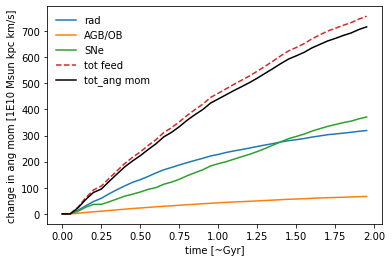

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(time_list, dLz_rad_list, label='rad')
ax.plot(time_list, dLz_AGB_list, label='AGB/OB')
ax.plot(time_list, dLz_SNe_list, label='SNe')
ax.plot(time_list, dLz_rad_list+dLz_AGB_list+dLz_SNe_list, label='tot feed', ls='dashed')
ax.plot(time_list, tot_angmom - tot_angmom[0], label='tot_ang mom', c='k')

ax.legend(frameon=False)
ax.set(xlabel='time [~Gyr]', ylabel='change in ang mom [1E10 Msun kpc km/s]')

plt.show()

In [4]:
from numba import njit
@njit
def _binned_average(x, y, bins):
    N = len(bins)
    
    sum_x_in_bin = np.zeros(N-1)
    sum_y_in_bin = np.zeros(N-1)
    N_in_bin = np.zeros(N-1)
    
    for i in range(len(x)):
        this_x = x[i]
        for j in range(N-1):
            if this_x > bins[j] and this_x < bins[j+1]:
                sum_x_in_bin[j] += x[i]
                sum_y_in_bin[j] += y[i]
                N_in_bin[j] += 1
    
    for j in range(N-1):
        sum_x_in_bin[j] /= N_in_bin[j]
        sum_y_in_bin[j] /= N_in_bin[j]
    
    return sum_x_in_bin, sum_y_in_bin
    
def binned_average(x, y, dx):
    xmin = np.min(x)
    xmax = np.max(x)

    bins = np.arange(xmin, xmax+dx, dx)
    return _binned_average(x, y, bins)

In [5]:
def compute_average_ang_mom_injection(sn):
    age = sn.Time - sn.part4.GFM_StellarFormationTime
    rad_mom = sn.part4.Cum_RadAngMomentumRealInjectedVec[:,2]
    AGB_mom = sn.part4.Cum_FeedbackAngMomentumAGBVec[:,2]
    SNe_mom = sn.part4.Cum_FeedbackAngMomentumInjectedVec[:,2]
    
    age_rad, mom_rad = binned_average(age, rad_mom, 0.1)
    age_AGB, mom_AGB = binned_average(age, AGB_mom, 0.1)
    age_SNe, mom_SNe = binned_average(age, SNe_mom, 0.1)
    
    return age_rad, mom_rad, mom_AGB, mom_SNe

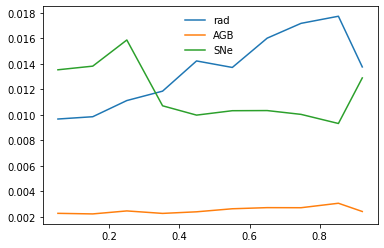

In [9]:
age, rad, AGB, SNe = compute_average_ang_mom_injection(sn_list[20])
fig, ax = plt.subplots(1, 1)

ax.plot(age, rad, label='rad')
ax.plot(age, AGB, label='AGB')
ax.plot(age, SNe, label='SNe')

ax.legend(frameon=False)

plt.show()

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


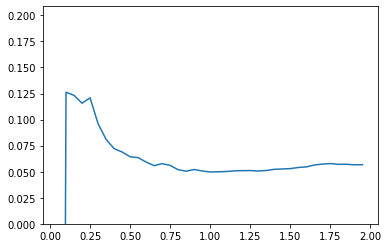

In [7]:
fig, ax = plt.subplots(1, 1)

ax.plot(time_list, (dLz_rad_list+dLz_AGB_list+dLz_SNe_list)/(tot_angmom - tot_angmom[0]) - 1)
ax.set(ylim=(0, None))

plt.show()

In [12]:
sn = read_snap(17, 0, lvl='lvl4-torquebug', parttype=None, fields=None)#, output_dir='output-noSne')
sn0 = read_snap(0, 0, lvl='lvl4-torquebug', parttype=None, fields=None)

In [4]:
dir(sn.part4)

['Acceleration',
 'BirthDensity',
 'BirthPos',
 'BirthVel',
 'ColumnDensity',
 'Coordinates',
 'CumFeedbackMomentum',
 'CumInjFeedbackMomentum',
 'CumInjFeedbackMomentumAGB',
 'CumSNIINumber',
 'CumSNIaNumber',
 'Cum_FeedbackAngMomentumAGBVec',
 'Cum_FeedbackAngMomentumInjectedVec',
 'Cum_RadAngMomentumRealInjectedVec',
 'Cum_RadMomentumRealInjected',
 'Cum_RadiationMomentumReleased',
 'FeedbackEnergy',
 'FeedbackMomentum',
 'FeedbackMomentumAGB',
 'GFM_InitialMass',
 'GFM_Metallicity',
 'GFM_Metals',
 'GFM_StellarFormationTime',
 'LocISMDens',
 'MassReleased',
 'Masses',
 'NormSphRadFeedback',
 'ParticleIDs',
 'Potential',
 'RadCoolShutoffTime',
 'RadFeedTau',
 'RadFeed_NumNgb',
 'RadiationMomentumReleased',
 'SNIINumber',
 'SNIaNumber',
 'Softenings',
 'StarsHsml',
 'StarsMaxRadius',
 'StromgrenRadius',
 'Velocities',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getite

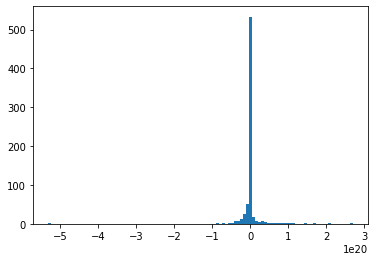

In [5]:
agb_dLz = sn.part4.Cum_FeedbackAngMomentumAGBVec[:,2]
rad_dLz = sn.part4.Cum_RadAngMomentumRealInjectedVec[:,2]
SNe_dLz = sn.part4.Cum_FeedbackAngMomentumInjectedVec[:,2]

fig, ax = plt.subplots(1, 1)

ax.hist(agb_dLz, bins=100)
plt.show()

In [9]:
print(np.sum(agb_dLz), np.sum(rad_dLz), np.sum(SNe_dLz))

6.705877e+20 7.028055 nan


/n/home01/abeane/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [5]:
def compute_totangmom(sn):
    tot = 0
    for i in range(5):
        if sn.NumPart_Total[i] > 0:
            center = np.array([200, 200, 200])
            pos = getattr(sn, 'part'+str(i)).pos - center
            vel = getattr(sn, 'part'+str(i)).vel
            if sn.MassTable[i] > 0.0:
                mass = sn.MassTable[i]
            else:
                mass = getattr(sn, 'part'+str(i)).mass
            
            Lz = np.cross(pos, mass*vel)[:,2]
            tot += np.sum(Lz)
    return tot

In [14]:
ang17 = compute_totangmom(sn)
ang0 = compute_totangmom(sn0)
print(ang0, ang17)

12094674636.566235 6264643392.46309
